# load ESC50

In [1]:
!git clone https://github.com/karolpiczak/ESC-50.git

Cloning into 'ESC-50'...
remote: Enumerating objects: 4199, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 4199 (delta 40), reused 38 (delta 18), pack-reused 4136
Receiving objects: 100% (4199/4199), 878.79 MiB | 13.95 MiB/s, done.
Resolving deltas: 100% (287/287), done.
Updating files: 100% (2011/2011), done.


In [2]:
import os
sound_list = os.listdir("/content/ESC-50/audio/")

In [3]:
sound_list[:5]

['1-5996-A-6.wav',
 '4-201988-A-44.wav',
 '2-72268-A-6.wav',
 '3-154957-A-1.wav',
 '4-185415-A-21.wav']



# EDA



# sample distribution

In [4]:
import pandas as pd
data = pd.read_csv("/content/ESC-50/meta/esc50.csv")

In [5]:
data.head()

filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A

<Axes: title={'center': 'sample distribution: 50 classes'}, xlabel='category'>

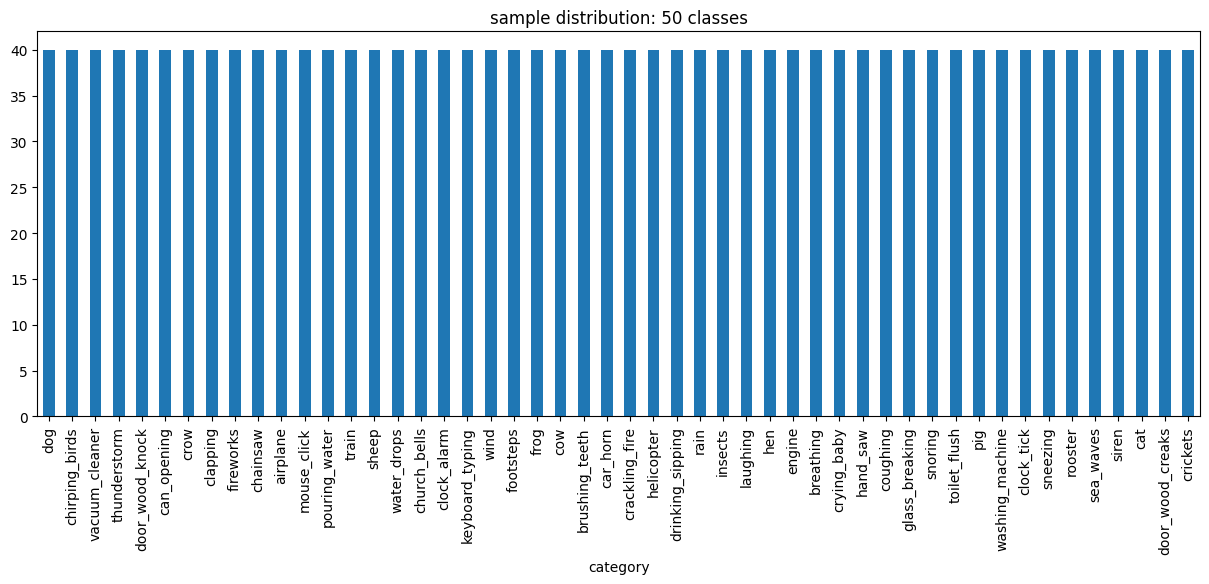

In [13]:
data["category"].value_counts().plot(kind="bar", title=f"sample distribution: {len(data['category'].value_counts())} classes", figsize=(15,5))

In [7]:
print(f"total sound sample: {len(data['filename'].unique())}")

total sound sample: 2000


### Class Insight from data source
- 5 major classes with 10 sub class
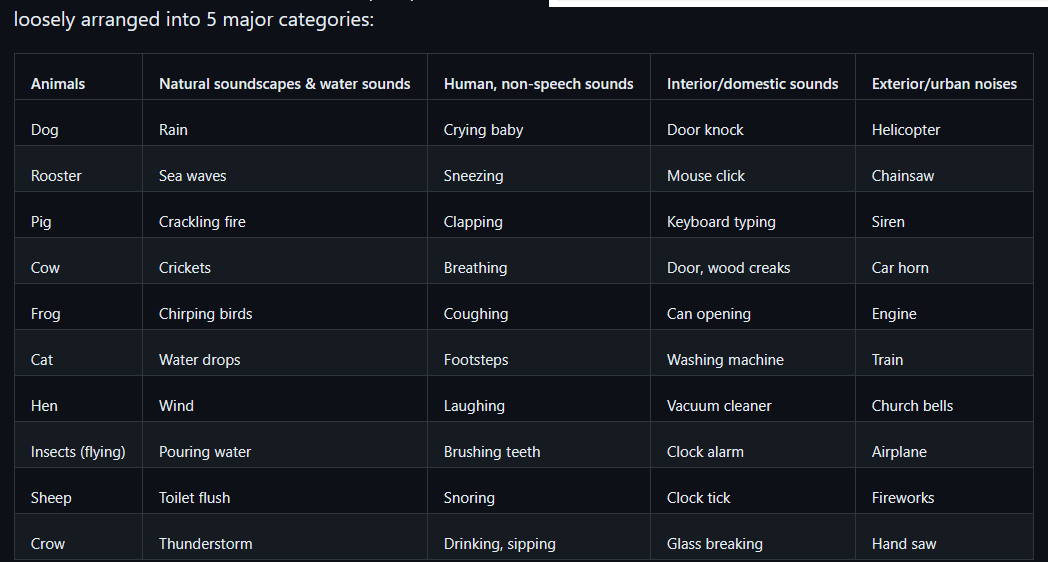

## Sound Wave exploration
credit to https://www.kaggle.com/code/drcapa/esc-50-eda-pytorch

In [14]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
import librosa.display
import IPython.display as display
import torchaudio
import torchaudio.transforms as T
import torch

In [15]:
def plot_signal_and_spectogram(data_array, samplerate):
    fig, axs = plt.subplots(1, 2, figsize=(22, 5))
    fig.subplots_adjust(hspace = .1, wspace=.2)
    axs = axs.ravel()
    x = range(len(data_array))
    y = data_array
    axs[0].plot(x, y)
    axs[0].grid()
    axs[1].specgram(data_array,Fs=samplerate, mode='psd', scale='dB')
    axs[0].set_title('Signal')
    axs[0].set_xlabel('Sample')
    axs[0].set_ylabel('Amplitude')
    axs[1].set_title('Spectogram')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Frequency')
    plt.grid()

def listen_example(file):
    return display.Audio(path+'audio/audio/'+file)

def get_file_list(category):
    file_list = data[data['category']==category]['filename'].to_list()
    return file_list

In [36]:
def make_features(wav_name, mel_bins, target_length=512):
    waveform, sr = torchaudio.load(wav_name)
    # assert sr == 16000, 'input audio sampling rate must be 16kHz'
    resample_rate = 16000
    resampler = T.Resample(sr, resample_rate, dtype=waveform.dtype)
    resampled_waveform = resampler(waveform)
    fbank = torchaudio.compliance.kaldi.fbank(
        waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
        window_type='hanning', num_mel_bins=mel_bins, dither=0.0, frame_shift=10)

    n_frames = fbank.shape[0]

    p = target_length - n_frames
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:target_length, :]

    fbank = (fbank - (-4.2677393)) / (4.5689974 * 2)
    return fbank

In [37]:
class_list = data['category'].unique()

In [38]:
print(f"total sound class: {len(class_list)}")

total sound class: 50


In [42]:
class_list

array(['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm',
       'door_wood_knock', 'can_opening', 'crow', 'clapping', 'fireworks',
       'chainsaw', 'airplane', 'mouse_click', 'pouring_water', 'train',
       'sheep', 'water_drops', 'church_bells', 'clock_alarm',
       'keyboard_typing', 'wind', 'footsteps', 'frog', 'cow',
       'brushing_teeth', 'car_horn', 'crackling_fire', 'helicopter',
       'drinking_sipping', 'rain', 'insects', 'laughing', 'hen', 'engine',
       'breathing', 'crying_baby', 'hand_saw', 'coughing',
       'glass_breaking', 'snoring', 'toilet_flush', 'pig',
       'washing_machine', 'clock_tick', 'sneezing', 'rooster',
       'sea_waves', 'siren', 'cat', 'door_wood_creaks', 'crickets'],
      dtype=object)

In [41]:
data

filename  fold  target        category  esc10  src_file take
0      1-100032-A-0.wav     1       0             dog   True    100032    A
1     1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2     1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3     1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4     1-101296-A-19.wav     1      19    thunderstorm  False    101296    A
...                 ...   ...     ...             ...    ...       ...  ...
1995   5-263831-B-6.wav     5       6             hen  False    263831    B
1996  5-263902-A-36.wav     5      36  vacuum_cleaner  False    263902    A
1997   5-51149-A-25.wav     5      25       footsteps  False     51149    A
1998    5-61635-A-8.wav     5       8           sheep  False     61635    A
1999     5-9032-A-0.wav     5       0             dog   True      9032    A

[2000 rows x 7 columns]

# sample of each major class

In [39]:
path_audio = "/content/ESC-50/audio/"

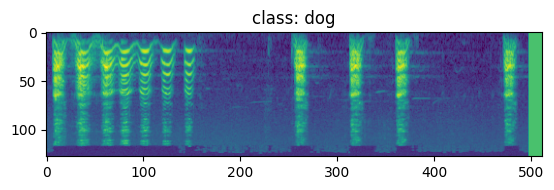

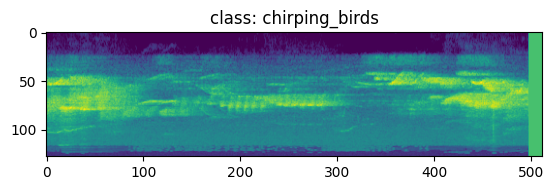

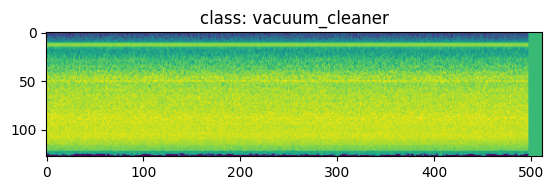

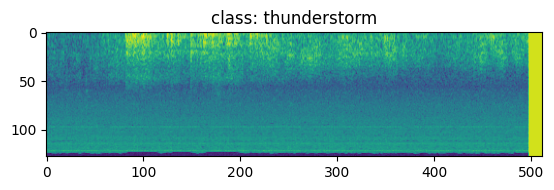

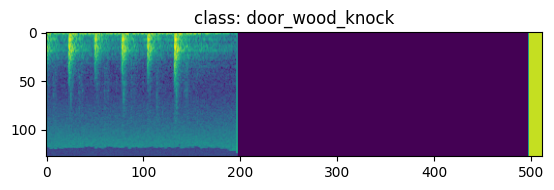

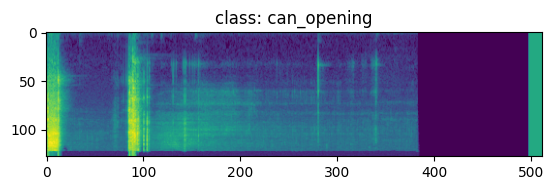

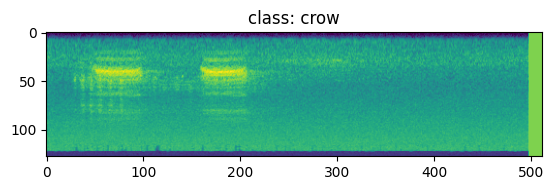

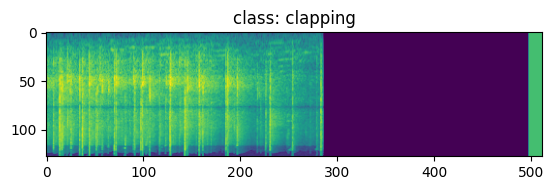

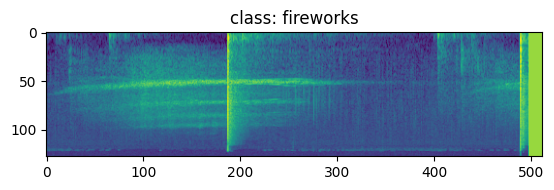

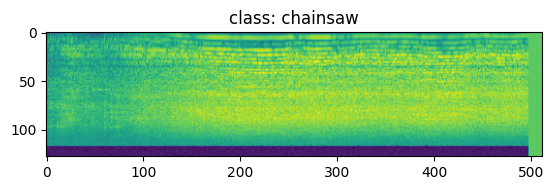

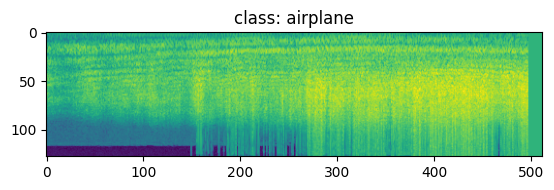

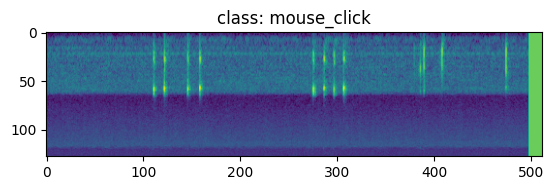

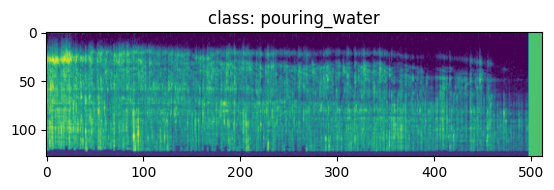

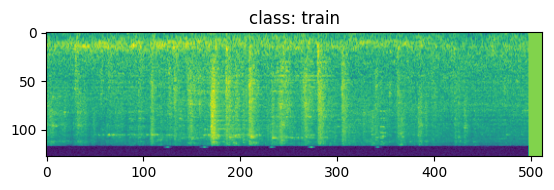

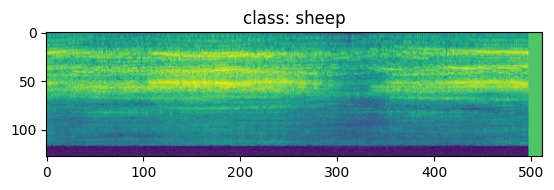

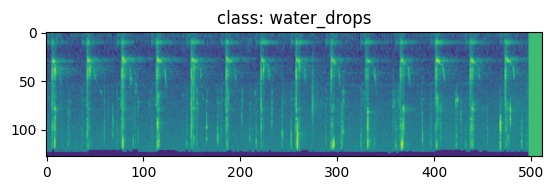

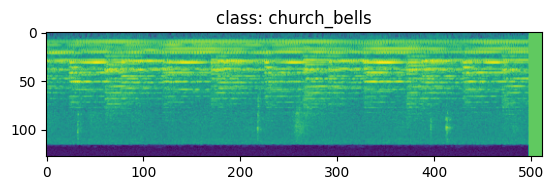

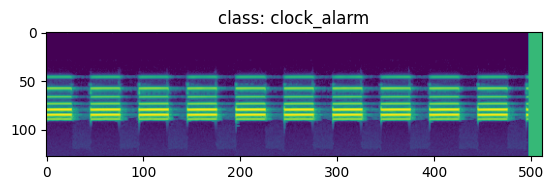

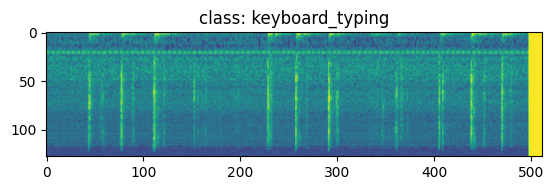

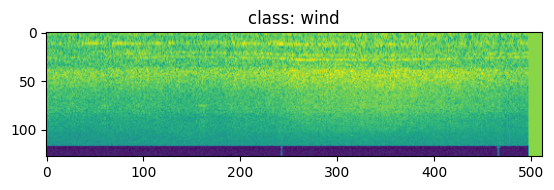

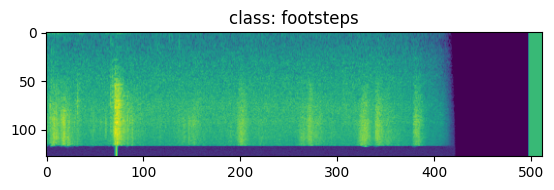

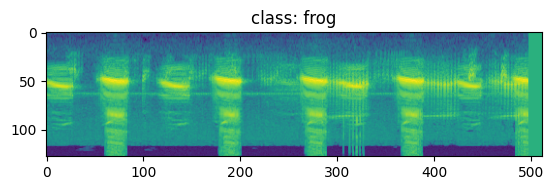

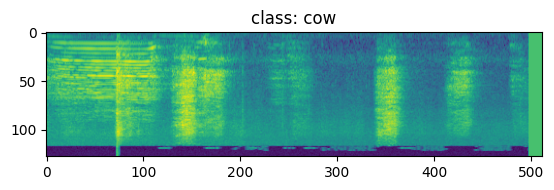

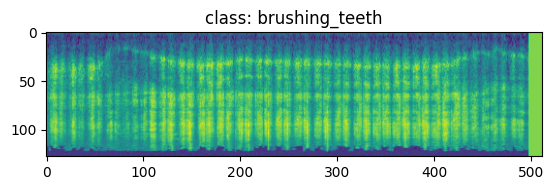

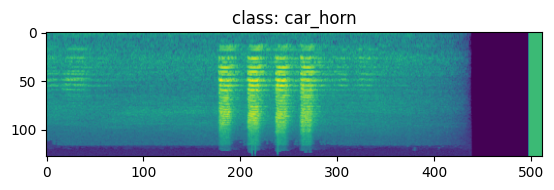

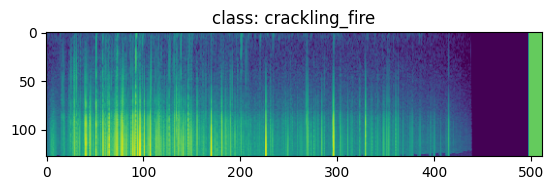

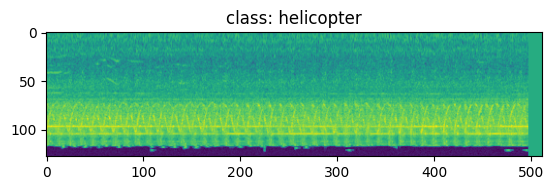

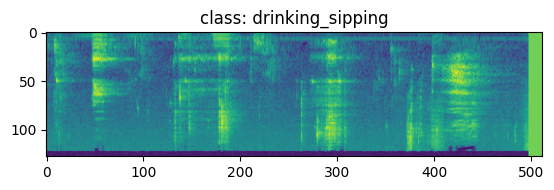

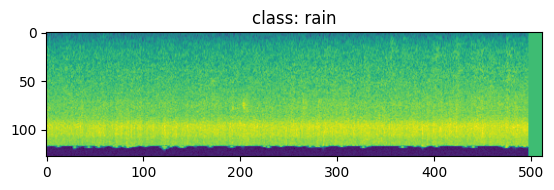

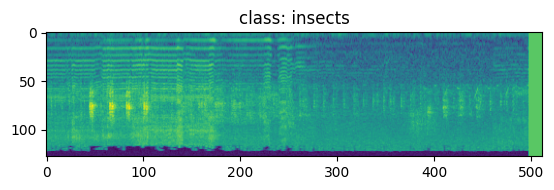

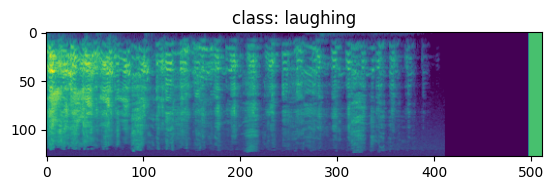

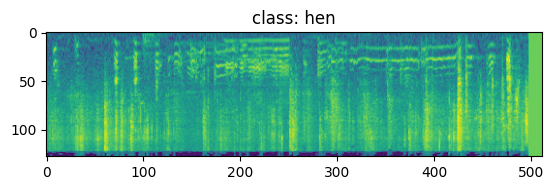

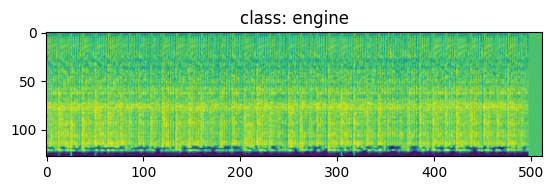

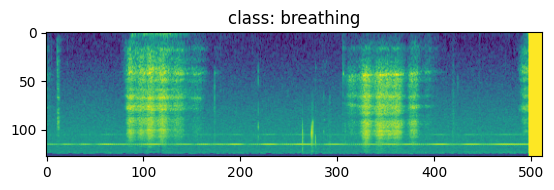

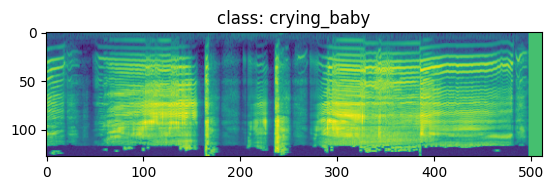

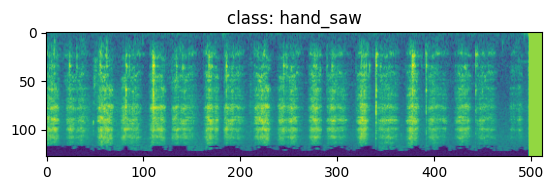

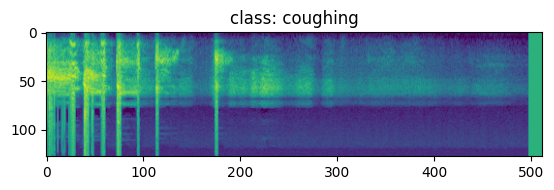

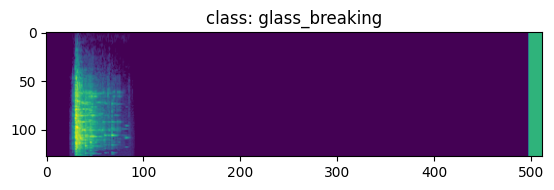

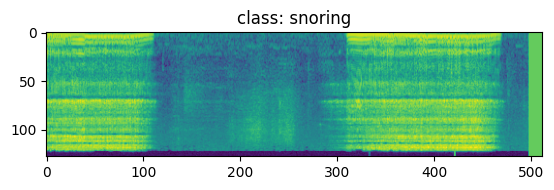

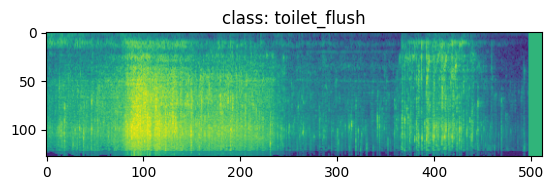

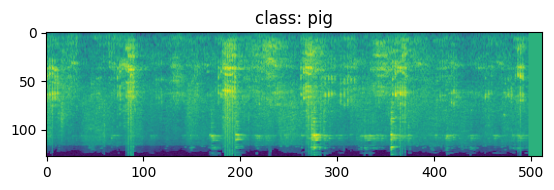

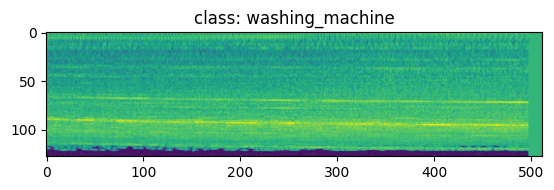

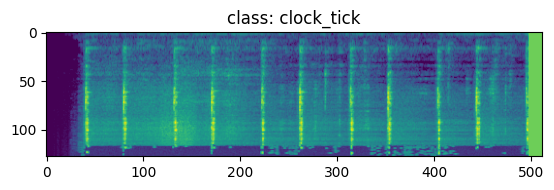

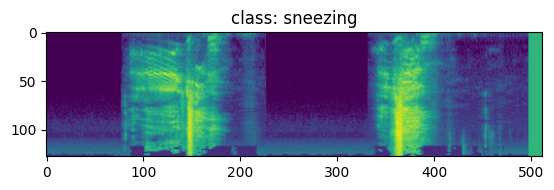

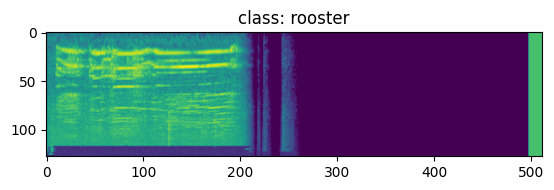

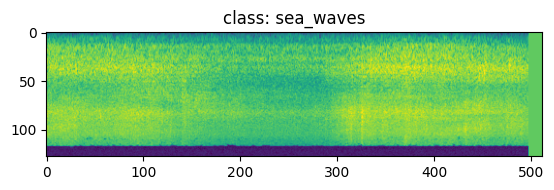

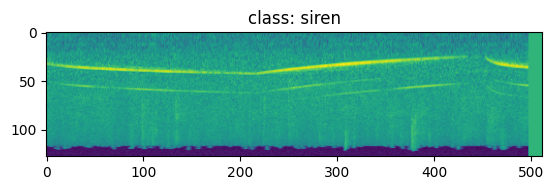

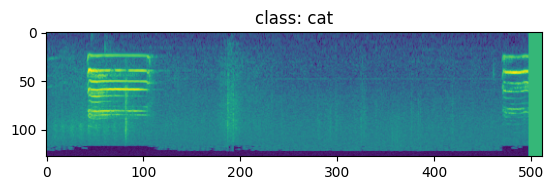

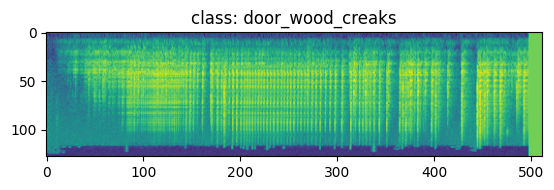

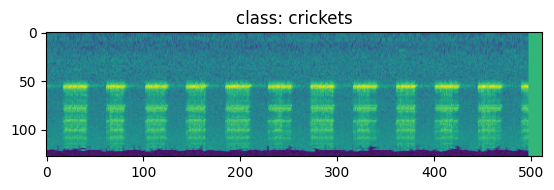

In [40]:
for i in range(len(class_list)):
    fname = data[data["category"] == class_list[i]].sample(1).filename.values[0]
    mel = make_features(path_audio + fname, 128)
    mel = mel.T
    plt.imshow(mel)
    plt.title(f"class: {class_list[i]}")
    plt.show()